In [22]:
#this notebook demonstrates C. autoethanogenum GSM analyses (Norman et al., 2018)
#click on cells and press 'run' to view results
#requires COBRApy (https://opencobra.github.io/cobrapy/)
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import json
import cobra
import gsmodutils
project = gsmodutils.GSMProject()

m = project.load_model()

m.summary()

IN FLUXES                   OUT FLUXES                 OBJECTIVES
--------------------------  -------------------------  ------------------
x_CARBON-MON...  10         x_CARBON-DIO...  5.04      EX_BIOMASS  0.0106
x_WATER           4.77      x_ACET           2.31
x_AMMONIA         0.0731    x_PROTON         2.28
x_Pi              0.0627    x_PPI            0.0194
x_HS              0.0018    x_BIOMASS        0.0106
x_NIACINE         0.000958  x_ADENOSYL-H...  0.000636
                            x_GLYCOL         0.000451


In [19]:
#SET MEDIA, GROWTH RATE AND ATP MAINTENANCE
#RUN THIS CELL BEFORE RUNNING ANALYSES
max_uptake = 10
media = {
        'EX_NIACINE':-1000,
        'EX_CARBON-MONOXIDE':-1000,
        'EX_AMMONIA':-1000,
        'EX_Pi':-1000,
        'EX_HS':-1000,
        'EX_WATER':-1000,
        'EX_PROTON':-1000,
}

biomass = 0.028
ngam = 2.154
m.reactions.get_by_id('ATPASE-RXN').bounds = (ngam,ngam)
gsmodutils.utils.io.load_medium(m, media)


m.reactions.get_by_id('EX_CARBON-MONOXIDE').lower_bound = -1*max_uptake #fix max uptake
m.objective = 'EX_BIOMASS'
sol = m.optimize()
v = sol.fluxes
print('Growth: '+str(v['EX_BIOMASS']))
print('acetate: '+str(v['EX_ACET']))
print('ethanol: '+str(v['EX_ETOH']))
print('CO2: '+str(v['EX_CARBON-DIOXIDE']))


m.save_model()

Growth: 0.010617311682246857
acetate: 2.305989780491317
ethanol: 0.0
CO2: 5.042733571885487


In [25]:
m = project.load_model()

m.reactions.get_by_id('EX_HYDROGEN-MOLECULE').bounds = (0,1000)

m.summary()

IN FLUXES                   OUT FLUXES                 OBJECTIVES
--------------------------  -------------------------  ------------------
x_CARBON-MON...  10         x_CARBON-DIO...  5.04      EX_BIOMASS  0.0106
x_WATER           4.77      x_ACET           2.31
x_AMMONIA         0.0731    x_PROTON         2.28
x_Pi              0.0627    x_PPI            0.0194
x_HS              0.0018    x_BIOMASS        0.0106
x_NIACINE         0.000958  x_ADENOSYL-H...  0.000636
                            x_GLYCOL         0.000451


In [16]:

m = project.load_model()
#thermodynamic consistency check 1, MUST BE INFEASIBLE.
for reaction in m.exchanges: #constrain all transporters to allow no uptake
    reaction.lower_bound = 0
m.reactions.get_by_id('ATPASE-RXN').bounds = (1,1)
sol = m.optimize()
print(sol.status)

m.diff()


cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


infeasible


TypeError: save_as_design() missing 2 required positional arguments: 'name' and 'description'

Growth: 0.0182909612412
acetate: 2.16576912201
ethanol: 0.0
CO2: 5.07361921082


In [30]:
#minimize absolute sum of enzyme-catalysed network flux (Row 1 of Table 3 in manuscript)

m = project.load_model() #reload model

cobra.manipulation.convert_to_irreversible(m)

#define list of enzyme-catalysed reactions based on PGDB from ScrumPy (i.e. exclude spontaneous and diffusion reactions)
with open('./reacs_for_min.json','r') as f:
    scrumpy_min_reactions = json.load(f)

#list of cobra model reaction ids
cobra_reactions = [x.id for x in m.reactions]

#list of reverse enzyme-catalysed reactions for irreversible model objective function
reverse_scrumpy_min_reactions = [x+'_reverse' for x in scrumpy_min_reactions if x+'_reverse' in cobra_reactions]

#CHECK THAT ALL SCRUMPY ENZYME-CATALYSED REACTIONS ARE IN COBRA MODEL (must evaluate as True):
print(len(set(scrumpy_min_reactions).intersection(cobra_reactions)) == len(scrumpy_min_reactions))

#add reversed reaction ids to objective function list and define list of coresponding reactions objects
min_reaction_ids = scrumpy_min_reactions+reverse_scrumpy_min_reactions
min_reactions = [m.reactions.get_by_id(x) for x in min_reaction_ids]

#define objective function
m.objective.direction = 'min'
m.objective = min_reactions

#constrain transporters to allow uptake of media components only
for reaction in m.exchanges:
    if '_reverse' in reaction.id:
        reaction.upper_bound = 0
    elif reaction.id not in media:
        reaction.lower_bound = 0
    else:
        reaction.lower_bound = -1000
        
#constrain biomass transporters (feature of ScrumPy models) to 0
for reaction in m.reactions: 
    if '_bm_tx' in reaction.id:
        reaction.upper_bound = 0
        reaction.lower_bound = 0

#enable production of biomass byproduct
m.reactions.adenosyl_homocysteine_bm_tx.bounds = (-1000,0) 

#biomass and atp maintenance constraints
m.reactions.get_by_id('EX_BIOMASS').bounds = (biomass,biomass)
m.reactions.get_by_id('ATPASE-RXN').bounds = (ngam,ngam)

sol = m.optimize()
v = sol.fluxes

print('acetate:',v['EX_ACET'])
print('ethanol:',v['EX_ETOH'])
print('CO2:',v['EX_CARBON-DIOXIDE'])
print('CO:',v['EX_CARBON-MONOXIDE'])

True
acetate: 0.061787589249
ethanol: 2.690969302
CO2: 12.0234379039
CO: -18.439543046


In [35]:
#minimize absolute sum of network flux (Row 2 of Table 3 in manuscript)

m = project.load_model() #reload model

cobra.manipulation.convert_to_irreversible(m)

#define objective function
m.objective.direction = 'min'
m.objective = m.reactions

#constrain transporters to allow uptake of media components only
for reaction in m.exchanges:
    if '_reverse' in reaction.id:
        reaction.upper_bound = 0
    elif reaction.id not in media:
        reaction.lower_bound = 0
    else:
        reaction.lower_bound = -1000
        
#constrain biomass transporters (feature of ScrumPy models) to 0
for reaction in m.reactions: 
    if '_bm_tx' in reaction.id:
        reaction.upper_bound = 0
        reaction.lower_bound = 0

#enable production of biomass byproduct
m.reactions.adenosyl_homocysteine_bm_tx.bounds = (-1000,0) 

#biomass and atp maintenance constraints
m.reactions.get_by_id('EX_BIOMASS').bounds = (biomass,biomass)
m.reactions.get_by_id('ATPASE-RXN').bounds = (ngam,ngam)

sol = m.optimize()
v = sol.fluxes

print('acetate:',v['EX_ACET'])
print('ethanol:',v['EX_ETOH'])
print('CO2:',v['EX_CARBON-DIOXIDE'])
print('CO:',v['EX_CARBON-MONOXIDE'])

acetate: 0.0675579124008
ethanol: 2.68635304347
CO2: 12.0165135161
CO: -18.4349267875


In [36]:
#generate a hierarchy of compounds in terms of the ATP yield associated with their production from CO
#fumarate, succinate, formate and glutamate production pathways are not discussed in article

m = project.load_model() #reload model

products = []

core_byproducts = ['EX_WATER','EX_PROTON','EX_CARBON-DIOXIDE']
biomass_byproducts = ['EX_ADENOSYL-HOMO-CYS','EX_PPI'] #ignore production of these
byproducts = core_byproducts+biomass_byproducts

while True:
    
    #set objective to maximise ATP yield
    m.objective.direction = 'max'
    m.objective = 'ATPASE-RXN'

    #constrain transporters to allow uptake of media components only
    for reaction in m.exchanges: 
        if reaction.id not in media:
            reaction.lower_bound = 0
        else:
            reaction.lower_bound = -1000
            
    #constrain biomass transporters (feature of ScrumPy models) to 0
    for reaction in m.reactions: 
        if '_bm_tx' in reaction.id or reaction.id in biomass_byproducts:
            reaction.upper_bound = 0
            reaction.lower_bound = 0

    m.reactions.get_by_id('EX_CARBON-MONOXIDE').lower_bound = -1 #fix max uptake
    
    #block products from previous iteration
    if len(products) > 0:
        for product in products:
            product.lower_bound = 0
            product.upper_bound = 0
    
    sol = m.optimize()
    v = sol.fluxes

    if sol.status == 'infeasible' or v['ATPASE-RXN'] < 1e-10: #exit condition: if no solution exists or ATP yield = 0.
        break

    ATP_yield = '%.3f' % (v['ATPASE-RXN']/-v['EX_CARBON-MONOXIDE'])
    
    #identify product
    for reaction in m.exchanges:
        if v[reaction.id] > 1e-10 and reaction.id not in byproducts:
            product = reaction
            products.append(product)
            v_prod = v[product.id]
            
    #build and print net conversion string
    product_stoichiometry = str(abs(v_prod/v_prod))
    product_name = product.id.replace('EX_','')
    net_conversion_RHS = [product_stoichiometry+' '+product_name]
    net_conversion_LHS = [str(1)+' '+'CARBON-MONOXIDE']
    for i in core_byproducts:
        byproduct_name = i.replace('EX_','')
        if v[i] < -1e-10:
            sto = str(abs(v[i]/v_prod))
            net_conversion_LHS.append(sto+' '+byproduct_name)
        elif v[i] > 1e-10:
            sto = str(abs(v[i]/v_prod))
            net_conversion_RHS.append(sto+' '+byproduct_name)
        else:
            continue
    print('Y_ATP =',ATP_yield+':',' + '.join(net_conversion_LHS)+' -> '+' + '.join(net_conversion_RHS))

Y_ATP = 0.375: 1 CARBON-MONOXIDE + 2.0 WATER -> 1.0 ACET + 1.0 PROTON + 2.0 CARBON-DIOXIDE
Y_ATP = 0.341: 1 CARBON-MONOXIDE + 3.0 WATER -> 1.0 ETOH + 4.0 CARBON-DIOXIDE
Y_ATP = 0.227: 1 CARBON-MONOXIDE + 3.0 WATER -> 1.0 SUC + 2.0 PROTON + 3.0 CARBON-DIOXIDE
Y_ATP = 0.222: 1 CARBON-MONOXIDE + 3.0 WATER -> 1.0 GLT + 1.0 PROTON + 4.0 CARBON-DIOXIDE
Y_ATP = 0.174: 1 CARBON-MONOXIDE + 3.0 WATER -> 1.0 D-LACTATE + 1.0 PROTON + 3.0 CARBON-DIOXIDE
Y_ATP = 0.174: 1 CARBON-MONOXIDE + 2.0 WATER -> 1.0 FUM + 2.0 PROTON + 2.0 CARBON-DIOXIDE
Y_ATP = 0.141: 1 CARBON-MONOXIDE + 5.0 WATER -> 1.0 BUTANEDIOL + 7.0 CARBON-DIOXIDE
Y_ATP = 0.136: 1 CARBON-MONOXIDE + 1.0 WATER -> 1.0 HYDROGEN-MOLECULE + 1.0 CARBON-DIOXIDE
Y_ATP = 0.136: 1 CARBON-MONOXIDE + 1.0 WATER -> 1.0 FORMATE + 1.0 PROTON


cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


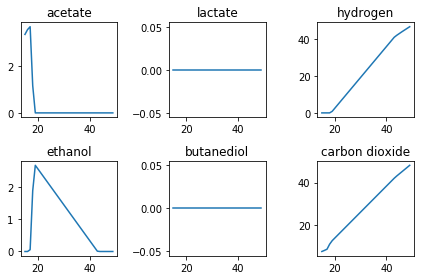

In [27]:
#non-carbon limited fba scan (figures 1, 2 & 3)

co_uptake_range = np.arange(15,50,1) #define range of co uptake fluxes (args: start, stop, step)

hydrogen_restricted = False #toggle hydrogen restriction (False = unrestricted, True = restricted)

m = project.load_model()

cobra.manipulation.convert_to_irreversible(m) #model to irreversible version for minimisation objective

#define list of enzyme-catalysed reactions based on PGDB from ScrumPy (i.e. exclude spontaneous and diffusion reactions)
with open('./reacs_for_min.json','r') as f:
    scrumpy_min_reactions = json.load(f)

#list of cobra model reaction ids
cobra_reactions = [x.id for x in m.reactions]

#list of reverse enzyme-catalysed reactions for irreversible model objective function
reverse_scrumpy_min_reactions = [x+'_reverse' for x in scrumpy_min_reactions if x+'_reverse' in cobra_reactions]

#CHECK THAT ALL SCRUMPY ENZYME-CATALYSED REACTIONS ARE IN COBRA MODEL (must evaluate as True):
#print(len(set(scrumpy_min_reactions).intersection(cobra_reactions)) == len(scrumpy_min_reactions))

#add reversed reaction ids to objective function list and define list of coresponding reactions objects
min_reaction_ids = scrumpy_min_reactions+reverse_scrumpy_min_reactions
min_reactions = [m.reactions.get_by_id(x) for x in min_reaction_ids]

#define objective function
m.objective.direction = 'min'
m.objective = min_reactions

#constrain transporters to allow uptake of media components only
for reaction in m.exchanges:
    if '_reverse' in reaction.id:
        reaction.upper_bound = 0
    elif reaction.id not in media:
        reaction.lower_bound = 0
    else:
        reaction.lower_bound = -1000
        
#constrain biomass transporters (feature of ScrumPy models) to 0
for reaction in m.reactions: 
    if '_bm_tx' in reaction.id:
        reaction.upper_bound = 0
        reaction.lower_bound = 0

#enable production of biomass byproduct
m.reactions.adenosyl_homocysteine_bm_tx.bounds = (-1000,0) 

#biomass and atp maintenance constraints
m.reactions.get_by_id('EX_BIOMASS').bounds = (biomass,biomass)
m.reactions.get_by_id('ATPASE-RXN').bounds = (ngam,ngam)

if hydrogen_restricted: #block hydrogen production to mimic thermodynamic constraint
    m.reactions.get_by_id('EX_HYDROGEN-MOLECULE').bounds = (0,0)

v_acetate = [] ; v_ethanol = [] ; v_lactate = [] ; v_butanediol = [] ; v_hydrogen = [] ; v_CO2 = []

#fba scan
for co_uptake in co_uptake_range:
    m.reactions.get_by_id('EX_CARBON-MONOXIDE').bounds = (-co_uptake,-co_uptake)
    sol = m.optimize()
    v = sol.fluxes
    v_acetate.append(v['EX_ACET'])
    v_ethanol.append(v['EX_ETOH'])
    v_lactate.append(v['EX_D-LACTATE'])
    v_butanediol.append(v['EX_BUTANEDIOL'])
    v_hydrogen.append(v['EX_HYDROGEN-MOLECULE'])
    v_CO2.append(v['EX_CARBON-DIOXIDE'])

#plot co uptake vs. products
fig, ax = plt.subplots(2,3)
ax[0,0].plot(co_uptake_range,v_acetate)
ax[0,0].set_title('acetate')

ax[1,0].plot(co_uptake_range,v_ethanol)
ax[1,0].set_title('ethanol')

ax[0,1].plot(co_uptake_range,v_lactate)
ax[0,1].set_title('lactate')

ax[1,1].plot(co_uptake_range,v_butanediol)
ax[1,1].set_title('butanediol')

ax[0,2].plot(co_uptake_range,v_hydrogen)
ax[0,2].set_title('hydrogen')

ax[1,2].plot(co_uptake_range,v_CO2)
ax[1,2].set_title('carbon dioxide')

plt.tight_layout()
plt.show()

cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


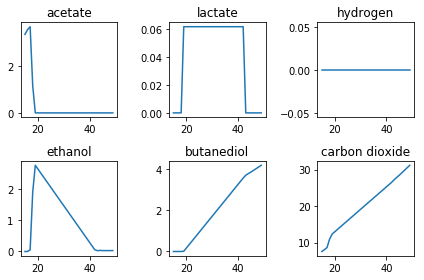

In [28]:
#non-carbon limited fba scan (figures 1, 2 & 3)

co_uptake_range = np.arange(15,50,1) #define range of co uptake fluxes (args: start, stop, step)

hydrogen_restricted = True #toggle hydrogen restriction (False = unrestricted, True = restricted)

m = project.load_model()

cobra.manipulation.convert_to_irreversible(m) #model to irreversible version for minimisation objective

#define list of enzyme-catalysed reactions based on PGDB from ScrumPy (i.e. exclude spontaneous and diffusion reactions)
with open('./reacs_for_min.json','r') as f:
    scrumpy_min_reactions = json.load(f)

#list of cobra model reaction ids
cobra_reactions = [x.id for x in m.reactions]

#list of reverse enzyme-catalysed reactions for irreversible model objective function
reverse_scrumpy_min_reactions = [x+'_reverse' for x in scrumpy_min_reactions if x+'_reverse' in cobra_reactions]

#CHECK THAT ALL SCRUMPY ENZYME-CATALYSED REACTIONS ARE IN COBRA MODEL (must evaluate as True):
#print(len(set(scrumpy_min_reactions).intersection(cobra_reactions)) == len(scrumpy_min_reactions))

#add reversed reaction ids to objective function list and define list of coresponding reactions objects
min_reaction_ids = scrumpy_min_reactions+reverse_scrumpy_min_reactions
min_reactions = [m.reactions.get_by_id(x) for x in min_reaction_ids]

#define objective function
m.objective.direction = 'min'
m.objective = min_reactions

#constrain transporters to allow uptake of media components only
for reaction in m.exchanges:
    if '_reverse' in reaction.id:
        reaction.upper_bound = 0
    elif reaction.id not in media:
        reaction.lower_bound = 0
    else:
        reaction.lower_bound = -1000
        
#constrain biomass transporters (feature of ScrumPy models) to 0
for reaction in m.reactions: 
    if '_bm_tx' in reaction.id:
        reaction.upper_bound = 0
        reaction.lower_bound = 0

#enable production of biomass byproduct
m.reactions.adenosyl_homocysteine_bm_tx.bounds = (-1000,0) 

#biomass and atp maintenance constraints
m.reactions.get_by_id('EX_BIOMASS').bounds = (biomass,biomass)
m.reactions.get_by_id('ATPASE-RXN').bounds = (ngam,ngam)

if hydrogen_restricted: #block hydrogen production to mimic thermodynamic constraint
    m.reactions.get_by_id('EX_HYDROGEN-MOLECULE').bounds = (0,0)

v_acetate = [] ; v_ethanol = [] ; v_lactate = [] ; v_butanediol = [] ; v_hydrogen = [] ; v_CO2 = []

#fba scan
for co_uptake in co_uptake_range:
    m.reactions.get_by_id('EX_CARBON-MONOXIDE').bounds = (-co_uptake,-co_uptake)
    sol = m.optimize()
    v = sol.fluxes
    v_acetate.append(v['EX_ACET'])
    v_ethanol.append(v['EX_ETOH'])
    v_lactate.append(v['EX_D-LACTATE'])
    v_butanediol.append(v['EX_BUTANEDIOL'])
    v_hydrogen.append(v['EX_HYDROGEN-MOLECULE'])
    v_CO2.append(v['EX_CARBON-DIOXIDE'])

#plot co uptake vs. products
fig, ax = plt.subplots(2,3)
ax[0,0].plot(co_uptake_range,v_acetate)
ax[0,0].set_title('acetate')

ax[1,0].plot(co_uptake_range,v_ethanol)
ax[1,0].set_title('ethanol')

ax[0,1].plot(co_uptake_range,v_lactate)
ax[0,1].set_title('lactate')

ax[1,1].plot(co_uptake_range,v_butanediol)
ax[1,1].set_title('butanediol')

ax[0,2].plot(co_uptake_range,v_hydrogen)
ax[0,2].set_title('hydrogen')

ax[1,2].plot(co_uptake_range,v_CO2)
ax[1,2].set_title('carbon dioxide')

plt.tight_layout()
plt.show()

In [33]:
m = project.load_model()
s = m.optimize()
s.fluxes["EX_ACET"]

RXN-11291                                   0.000000
THREDEHYD-RXN                               0.000619
RXN-14227                                   0.000000
RXN-14883                                   0.000000
RXN-14882                                   0.000000
ARGSUCCINSYN-RXN                            0.000000
ADENINE-DEAMINASE-RXN                       0.000000
DIOHBUTANONEPSYN-RXN                        0.000047
RXN1F-20                                    0.000000
UDPGLCNACEPIM-RXN                           0.000000
RXN-14715                                   0.000000
DTDPGLUCOSEPP-RXN                           0.000000
HOMSUCTRAN-RXN                              0.000000
GLUTAMIDOTRANS-RXN                          0.000432
SPONTPRO-RXN                               -0.001379
CYTIDEAM2-RXN                               0.000154
RXN-13290                                   0.000000
ADPREDUCT-RXN                              -0.001094
4-CARBOXYMUCONOLACTONE-DECARBOXYLASE-RXN    0.